### Introduction

In the previous post, we implemented the upsampling and made sure it is correct
by comparing it to the implementation of the [scikit-image library](http://scikit-image.org/).
To be more specific we had _FCN-32_ _Segmentation_ network implemented which is
described in the paper _Fully convolutional networks for semantic segmentation_.

In this post we will perform a simple training: we will get a sample image from
[PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset along with annotation,
train our network on them and test our network on the same image. It was done this way
so that it can also be run on CPU -- it takes only 10 iterations for the training to complete.
Another point of this post is to show that segmentation that our network (FCN-32s) produces is
very coarse -- even if we run it on the same image that we were training it on. In this post
we tackle this problem by performing Conditional Random Field post-processing stage, which
refines our segmentation by taking into account pure RGB features of image and probabilities
produced by our network. Overall, we get a refined segmentation. The set-up of this post
is very simple on purpose. Similar approach to Segmentation was described in the paper
_Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al.

The blog post is created using jupyter notebook. After each chunk of a code
you can see the result of its evaluation. You can also get the notebook
file from [here](http://google.com). The content of the blog post
is partially borrowed from [slim walkthough notebook](https://github.com/tensorflow/models/blob/master/slim/slim_walkthough.ipynb).

### Setup



To be able to run the code, you will need to have Tensorflow installed. I have used _r0.12_.
You will need to use [this fork of _tensorflow/models_](https://github.com/tensorflow/models/pull/684). 

I am also using scikit-image library and numpy for this tutorial plus other
dependencies. One of the ways to install them is to download _Anaconda_ software
package for python.

Follow all the other steps described in the previous posts -- it shows how to download
the _VGG-16_ model and I also forked the 

### Upsampling helper functions and Image Loading

In this part, we define helper functions that were used in previous post.
If you recall, we used upsampling to upsample the downsampled predictions
that we get from our network. We get downsampled predictions because of max-pooling
layers that are used in _VGG-16_ network.

We also write code for image and respective ground-truth segmentation loading.
The code is well-commented, so don't be afraid to read it.

In [1]:
import numpy as np

def get_kernel_size(factor):
    """
    Find the kernel size given the desired factor of upsampling.
    """
    return 2 * factor - factor % 2


def upsample_filt(size):
    """
    Make a 2D bilinear kernel suitable for upsampling of the given (h, w) size.
    """
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)


def bilinear_upsample_weights(factor, number_of_classes):
    """
    Create weights matrix for transposed convolution with bilinear filter
    initialization.
    """
    
    filter_size = get_kernel_size(factor)
    
    weights = np.zeros((filter_size,
                        filter_size,
                        number_of_classes,
                        number_of_classes), dtype=np.float32)
    
    upsample_kernel = upsample_filt(filter_size)
    
    for i in xrange(number_of_classes):
        
        weights[:, :, i, i] = upsample_kernel
    
    return weights

In [2]:
%matplotlib inline

from __future__ import division

import os
import sys
import tensorflow as tf
import skimage.io as io
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"] = '1'
#sys.path.append("/home/dpakhom1/workspace/my_models/slim/")
#checkpoints_dir = '/home/dpakhom1/checkpoints'

image_filename = 'dataset/training/images/satImage_001.png'
annotation_filename = 'dataset/training/groundtruth/satImage_001.png'

image_filename_placeholder = tf.placeholder(tf.string)
annotation_filename_placeholder = tf.placeholder(tf.string)
is_training_placeholder = tf.placeholder(tf.bool)

feed_dict_to_use = {image_filename_placeholder: image_filename,
                    annotation_filename_placeholder: annotation_filename,
                    is_training_placeholder: True}

image_tensor = tf.read_file(image_filename_placeholder)
annotation_tensor = tf.read_file(annotation_filename_placeholder)

image_tensor = tf.image.decode_jpeg(image_tensor, channels=3)
annotation_tensor = tf.image.decode_png(annotation_tensor, channels=1)

# Get ones for each class instead of a number -- we need that
# for cross-entropy loss later on. Sometimes the groundtruth
# masks have values other than 1 and 0. 
class_labels_tensor = tf.equal(annotation_tensor, 1)
background_labels_tensor = tf.not_equal(annotation_tensor, 1)

# Convert the boolean values into floats -- so that
# computations in cross-entropy loss is correct
bit_mask_class = tf.to_float(class_labels_tensor)
bit_mask_background = tf.to_float(background_labels_tensor)

combined_mask = tf.concat(concat_dim=2, values=[bit_mask_class,
                                                bit_mask_background])

# Lets reshape our input so that it becomes suitable for 
# tf.softmax_cross_entropy_with_logits with [batch_size, num_classes]
flat_labels = tf.reshape(tensor=combined_mask, shape=(-1, 2))


### Loss function definition and training using Adam Optimization Algorithm.

In this part, we connect everything together: add the upsampling layer to our network,
define the loss function that can be differentiated and perform training.

Following the _Fully convolutional networks for semantic segmentation_ paper, we define loss
as a pixel-wise cross-entropy. We can do this, because after upsampling we
got the predictions of the same size as the input and we can compare the acquired segmentation
to the respective ground-truth segmentation:

$$
E = -\sum_{n=1}^{N} \sum_{k=1}^{K} t_{nk}ln(y_{nk})
$$

Where $N$ is a number of pixels, $K$ - number of classes, $t_{nk}$ a variable representing
the ground-truth with 1-of-$K$ coding scheme, $y_{nk}$ represent our predictions (softmax output).

For this case we use Adam optimizer because it require less parameter tuning to get good results.

In this particular case we train and evaluate our results on one image -- which is a much simpler case
compared to real-world scenario. We do this to show the drawback of the approach -- just
to show that is has poor localization copabilities. If this holds for this simple case, it will
also show similar of worse results on unseen images.

In [2]:
import numpy as np
import tensorflow as tf
import sys
import os
from matplotlib import pyplot as plt

fig_size = [15, 4]
plt.rcParams["figure.figsize"] = fig_size

import urllib2

slim = tf.contrib.slim

from nets import vgg
from preprocessing import vgg_preprocessing

# Load the mean pixel values and the function
# that performs the subtraction from each pixel
from preprocessing.vgg_preprocessing import (_mean_image_subtraction,
                                            _R_MEAN, _G_MEAN, _B_MEAN)

upsample_factor = 32
number_of_classes = 2
log_folder = '/home/dpakhom1/tf_projects/segmentation/log_folder'

#vgg_checkpoint_path = os.path.join(checkpoints_dir, 'vgg_16.ckpt')

# Convert image to float32 before subtracting the
# mean pixel value
image_float = tf.to_float(image_tensor, name='ToFloat')

# Subtract the mean pixel value from each pixel
mean_centered_image = _mean_image_subtraction(image_float,
                                          [_R_MEAN, _G_MEAN, _B_MEAN])

processed_images = tf.expand_dims(mean_centered_image, 0)

upsample_filter_np = bilinear_upsample_weights(upsample_factor,
                                               number_of_classes)

upsample_filter_tensor = tf.constant(upsample_filter_np)

# Define the model that we want to use -- specify to use only two classes at the last layer
with slim.arg_scope(vgg.vgg_arg_scope()):
    
    logits, end_points = vgg.vgg_16(processed_images,
                           num_classes=2,
                           is_training=is_training_placeholder,
                           spatial_squeeze=False,
                           fc_conv_padding='SAME')

downsampled_logits_shape = tf.shape(logits)

# Calculate the ouput size of the upsampled tensor
upsampled_logits_shape = tf.pack([
                                  downsampled_logits_shape[0],
                                  downsampled_logits_shape[1] * upsample_factor,
                                  downsampled_logits_shape[2] * upsample_factor,
                                  downsampled_logits_shape[3]
                                 ])

# Perform the upsampling
upsampled_logits = tf.nn.conv2d_transpose(logits, upsample_filter_tensor,
                                 output_shape=upsampled_logits_shape,
                                 strides=[1, upsample_factor, upsample_factor, 1])

# Flatten the predictions, so that we can compute cross-entropy for
# each pixel and get a sum of cross-entropies.
flat_logits = tf.reshape(tensor=upsampled_logits, shape=(-1, number_of_classes))

cross_entropies = tf.nn.softmax_cross_entropy_with_logits(logits=flat_logits,
                                                          labels=flat_labels)

cross_entropy_sum = tf.reduce_sum(cross_entropies)

# Tensor to get the final prediction for each pixel -- pay 
# attention that we don't need softmax in this case because
# we only need the final decision. If we also need the respective
# probabilities we will have to apply softmax.
pred = tf.argmax(upsampled_logits, dimension=3)

probabilities = tf.nn.softmax(upsampled_logits)

# Here we define an optimizer and put all the variables
# that will be created under a namespace of 'adam_vars'.
# This is done so that we can easily access them later.
# Those variables are used by adam optimizer and are not
# related to variables of the vgg model.

# We also retrieve gradient Tensors for each of our variables
# This way we can later visualize them in tensorboard.
# optimizer.compute_gradients and optimizer.apply_gradients
# is equivalent to running:
# train_step = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cross_entropy_sum)
with tf.variable_scope("adam_vars"):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
    gradients = optimizer.compute_gradients(loss=cross_entropy_sum)
    
    for grad_var_pair in gradients:
        
        current_variable = grad_var_pair[1]
        current_gradient = grad_var_pair[0]
        
        # Relace some characters from the original variable name
        # tensorboard doesn't accept ':' symbol
        gradient_name_to_save = current_variable.name.replace(":", "_")
        
        # Let's get histogram of gradients for each layer and
        # visualize them later in tensorboard
        tf.summary.histogram(gradient_name_to_save, current_gradient) 
    
    train_step = optimizer.apply_gradients(grads_and_vars=gradients)
    
# Now we define a function that will load the weights from VGG checkpoint
# into our variables when we call it. We exclude the weights from the last layer
# which is responsible for class predictions. We do this because 
# we will have different number of classes to predict and we can't
# use the old ones as an initialization.
vgg_except_fc8_weights = slim.get_variables_to_restore(exclude=['vgg_16/fc8', 'adam_vars'])

# Here we get variables that belong to the last layer of network.
# As we saw, the number of classes that VGG was originally trained on
# is different from ours -- in our case it is only 2 classes.
vgg_fc8_weights = slim.get_variables_to_restore(include=['vgg_16/fc8'])

adam_optimizer_variables = slim.get_variables_to_restore(include=['adam_vars'])

# Add summary op for the loss -- to be able to see it in
# tensorboard.
tf.summary.scalar('cross_entropy_loss', cross_entropy_sum)

# Put all summary ops into one op. Produces string when
# you run it.
merged_summary_op = tf.summary.merge_all()

# Create the summary writer -- to write all the logs
# into a specified file. This file can be later read
# by tensorboard.
summary_string_writer = tf.summary.FileWriter(log_folder)

# Create the log folder if doesn't exist yet
if not os.path.exists(log_folder):
    os.makedirs(log_folder)

# Create an OP that performs the initialization of
# values of variables to the values from VGG.
read_vgg_weights_except_fc8_func = slim.assign_from_checkpoint_fn(
                                   vgg_checkpoint_path,
                                   vgg_except_fc8_weights)

# Initializer for new fc8 weights -- for two classes.
vgg_fc8_weights_initializer = tf.variables_initializer(vgg_fc8_weights)

# Initializer for adam variables
optimization_variables_initializer = tf.variables_initializer(adam_optimizer_variables)

with tf.Session() as sess:
    
    # Run the initializers.
    read_vgg_weights_except_fc8_func(sess)
    sess.run(vgg_fc8_weights_initializer)
    sess.run(optimization_variables_initializer)
    
    train_image, train_annotation = sess.run([image_tensor, annotation_tensor],
                                              feed_dict=feed_dict_to_use)
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(train_image)
    ax1.set_title('Input image')
    probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
    ax2.set_title('Input Ground-Truth Annotation')
    plt.show()
    
    # Let's perform 10 interations
    for i in range(10):
        
        loss, summary_string = sess.run([cross_entropy_sum, merged_summary_op],
                                        feed_dict=feed_dict_to_use)
        
        sess.run(train_step, feed_dict=feed_dict_to_use)
        
        pred_np, probabilities_np = sess.run([pred, probabilities],
                                              feed_dict=feed_dict_to_use)
        
        summary_string_writer.add_summary(summary_string, i)
        
        cmap = plt.get_cmap('bwr')
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.imshow(np.uint8(pred_np.squeeze() != 1), vmax=1.5, vmin=-0.4, cmap=cmap)
        ax1.set_title('Argmax. Iteration # ' + str(i))
        probability_graph = ax2.imshow(probabilities_np.squeeze()[:, :, 0])
        ax2.set_title('Probability of the Class. Iteration # ' + str(i))
        
        plt.colorbar(probability_graph)
        plt.show()
        
        print("Current Loss: " +  str(loss))
    
    feed_dict_to_use[is_training_placeholder] = False
    
    final_predictions, final_probabilities, final_loss = sess.run([pred,
                                                                   probabilities,
                                                                   cross_entropy_sum],
                                                         feed_dict=feed_dict_to_use)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    ax1.imshow(np.uint8(final_predictions.squeeze() != 1),
               vmax=1.5,
               vmin=-0.4,
               cmap=cmap)
    
    ax1.set_title('Final Argmax')
    
    
    probability_graph = ax2.imshow(final_probabilities.squeeze()[:, :, 0])
    ax2.set_title('Final Probability of the Class')
    plt.colorbar(probability_graph)
    
    plt.show()
    
    print("Final Loss: " +  str(final_loss))
    
    
    

summary_string_writer.close()



ImportError: No module named 'urllib2'

As you can see, the results are very coarse -- and these are results that we get
by running our network on the same image that we were training on. This is very
common problem in segmentation -- the results are usually coarse. There are different
approaches that can help to solve this problem -- one of them is to use skip-connections.
The main idea is that predictions are made by fusing predictions from different layers
of the network. Because in earlier layers of a network the downsampling factor is smaller,
it is possible to get a better localization by making predictions based on those layers.
This approach is described in the _Fully convolutional networks for semantic segmentation_ by
Long et al. This approach gave rise to _FCN-16s_ and _FCN-8s_ architectures.

Another approach is based on using _atrous convolutions_ and _fully connected conditional random fields_.
The approach is described in the _Semantic Image Segmentation with Deep Convolutional Nets and Fully Connected CRFs_ by Chen et al. In this post we will only use CRF post-processing stage to show how it can improve
the results.

It is also worth mentioning that the current model was trained using dropout
applied to fully connected layers (fully connected layers that we casted to convolutional ones). This
approach is described in _Dropout: a simple way to prevent neural networks from overfitting_
by Srivastava et al. _Dropout_ is a regularization technique for training networks. It has a
very good theoretical description while the implementation is very simple: we just
randomly choose a certain number of neurons during each training step, perform
inference and backpropagation only through them. While from the theoretical side,
it can be seen as training a collection of thinned networks with weight sharing, where
each network gets trained very rarely. During the test time, we average predictions
from all of these networks. In the paper, the authors showed that dropout in case
of linear regression is equivalent, in expection, to ridge regression.
In our specific case we use dropout only for fully-connected
layers (fully connected layers that we casted to convolutional ones). This explains
why the loss for the final model is almost twice less then during the last iteration --
because for the final inference we used averaging.

Overall, we can see that our segmentation is still quite coarse and we need to perform
some additional step. In the next section we will use CRF post-processing step to make
segmentation finer.


### Conditional Random Field post-processing

Conditional Random Field is a specific type of graphical model. In our case it helps to estimate
the posterior distribution given predictions from our network and raw _RGB_ features that are 
represented by our image. It does that by minimizing the energy function which are defined by
the user. In our case the effect is very similar to _bilateral_ filter which takes into account
the spatial closeness of pixels and their similarity in RGB feature space (intensity space).

On a very simple level, it uses _RGB_ features to make prediction more localized -- for example
the border is usually represented as a big intensity change -- this acts as a strong factor that
objects that lie on different side of this border belong to different classes. It also penalizes
small segmentation regions -- for example it is unlikely that a small region of 20 or 50 pixels
is a correct segmentation. Objects are usually represented by big spatially adjacent regions.

Below you can see how this post-processing stage affects our results. We are using fully connected
conditional random fields which is described in Efficient inference in _fully connected crfs with gaussian edge potentials_ paper.

For this part I used a little bit older version of the fully connected CRF library which you can
find [here](https://github.com/lucasb-eyer/pydensecrf/tree/94d1cddab277e6e93812dfe7daca7d4693560758).


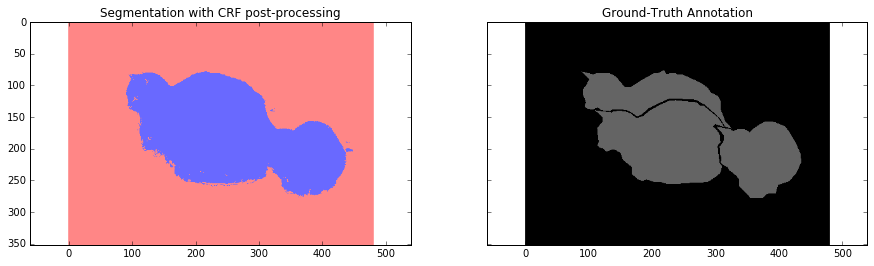

In [7]:
import sys

path = "/home/dpakhom1/dense_crf_python/"
sys.path.append(path)

import pydensecrf.densecrf as dcrf

from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, softmax_to_unary

import skimage.io as io

image = train_image

softmax = final_probabilities.squeeze()

softmax = processed_probabilities.transpose((2, 0, 1))

# The input should be the negative of the logarithm of probability values
# Look up the definition of the softmax_to_unary for more information
unary = softmax_to_unary(processed_probabilities)

# The inputs should be C-continious -- we are using Cython wrapper
unary = np.ascontiguousarray(unary)

d = dcrf.DenseCRF(image.shape[0] * image.shape[1], 2)

d.setUnaryEnergy(unary)

# This potential penalizes small pieces of segmentation that are
# spatially isolated -- enforces more spatially consistent segmentations
feats = create_pairwise_gaussian(sdims=(10, 10), shape=image.shape[:2])

d.addPairwiseEnergy(feats, compat=3,
                    kernel=dcrf.DIAG_KERNEL,
                    normalization=dcrf.NORMALIZE_SYMMETRIC)

# This creates the color-dependent features --
# because the segmentation that we get from CNN are too coarse
# and we can use local color features to refine them
feats = create_pairwise_bilateral(sdims=(50, 50), schan=(20, 20, 20),
                                   img=image, chdim=2)

d.addPairwiseEnergy(feats, compat=10,
                     kernel=dcrf.DIAG_KERNEL,
                     normalization=dcrf.NORMALIZE_SYMMETRIC)
Q = d.inference(5)

res = np.argmax(Q, axis=0).reshape((image.shape[0], image.shape[1]))

cmap = plt.get_cmap('bwr')

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(res, vmax=1.5, vmin=-0.4, cmap=cmap)
ax1.set_title('Segmentation with CRF post-processing')
probability_graph = ax2.imshow(np.dstack((train_annotation,)*3)*100)
ax2.set_title('Ground-Truth Annotation')
plt.show()


### Conclusion and Discussion

In this tutorial we saw one drawback of Convolutional Neural Networks when applied to
the problem of segmentation -- coarse segmentation results. We saw that is happens due to
the usage of max-pooling layers in the architecture of the _VGG-16_ network.

We performed training in a simplified case, by defining a cross-etropy loss pixel-wise
and using back-propagation to perform the weights update.

We approached the problem of coarse segmentation results by using Conditional Random Fields (CRFs)
and achieved better results.